In [147]:
#from google.colab import drive
#drive.mount('/content/drive')

In [148]:
%matplotlib inline
from tqdm import tqdm
import numpy as np 
import pandas as pd
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import random

plt.rcParams['figure.figsize'] = [20, 15]

import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
from math import radians, cos, sin, asin, sqrt
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb
from sklearn.metrics import accuracy_score

import json


In [149]:
def check_basic(df, df_type="train"):
    print("{} DF has {} rows and {} columns".format(df_type,df.shape[0], df.shape[1]))
    if df.id.nunique() == df.shape[0]:
        print("1. Id is unique")
    if not df.isnull().any().any(): 
        print("2. No missing value")
    if train.duplicated(keep='first').sum() == 0:
        print("3. No duplicate record")
    if df_type == 'train':
        trip_duration_diff = (pd.to_datetime(train.dropoff_datetime) - pd.to_datetime(train.pickup_datetime)).map(lambda x :x.total_seconds())
        if len(df[np.abs(trip_duration_diff.values - df['trip_duration'].values) > 1]) == 0:
            print("4. Trip_duration is consistent with pickup and dropoff times.")
           

        
def value_percentages(col):
    val = col.groupby(by=col).count().sort_values(ascending=False)
    total = val.sum()
    return (((val / total)*100).round(1)).to_dict()

def num_values(col):
    return col.nunique()

def missing_percentage(col):
    per = col.isna().mean()*100
    return per.round(1)    

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [150]:
#pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [151]:
# !unzip ../input/nyc-taxi-trip-duration/train.zip -d nyc-taxi-trip-duration
# !unzip ../input/nyc-taxi-trip-duration/test.zip -d nyc-taxi-trip-duration
# !unzip ../input/nyc-taxi-trip-duration/sample_submission.zip -d nyc-taxi-trip-duration
#%cd /content/drive/MyDrive/CSC14115 - KHDLUD

In [152]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [153]:
train.pickup_datetime=pd.to_datetime(train.pickup_datetime)
test.pickup_datetime=pd.to_datetime(train.pickup_datetime)
train.dropoff_datetime=pd.to_datetime(train.dropoff_datetime)



In [154]:
train['vendor_id'] = train['vendor_id'].astype(str)
test['vendor_id'] = test['vendor_id'].astype(str)

In [155]:
train.describe(datetime_is_numeric = True)

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,2016-04-01 10:10:24.940037120,2016-04-01 10:26:24.432310528,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
min,2016-01-01 00:00:17,2016-01-01 00:03:31,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,2016-02-17 16:46:04.249999872,2016-02-17 17:05:32.500000,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2016-04-01 17:19:40,2016-04-01 17:35:12,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2016-05-15 03:56:08.750000128,2016-05-15 04:10:51.750000128,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2016-06-30 23:59:39,2016-07-01 23:02:03,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06
std,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03


In [156]:
num_cols = list(train.select_dtypes(exclude='object').columns)
cate_cols = list(train.select_dtypes(include='object').columns)
print("Num cols: ",num_cols)
print("Cate cols: ",cate_cols)

Num cols:  ['pickup_datetime', 'dropoff_datetime', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'trip_duration']
Cate cols:  ['id', 'vendor_id', 'store_and_fwd_flag']


In [157]:
train[num_cols].agg([value_percentages, num_values])

,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
value_percentages,"{2016-03-04 08:07:34: 0.0, 2016-01-12 18:48:44...","{2016-02-19 19:25:04: 0.0, 2016-05-16 19:40:28...","{1: 70.9, 2: 14.4, 5: 5.4, 3: 4.1, 6: 3.3, 4: ...","{-73.9822006225586: 0.0, -73.98213958740233: 0...","{40.77410125732422: 0.0, 40.774089813232415: 0...","{-73.98233032226561: 0.0, -73.98209381103516: ...","{40.774311065673835: 0.0, 40.77433013916016: 0...","{368: 0.1, 408: 0.1, 348: 0.1, 367: 0.1, 358: ..."
num_values,1380222,1380377,10,23047,45245,33821,62519,7417


In [158]:
train[cate_cols].agg([value_percentages, num_values])

,id,vendor_id,store_and_fwd_flag
value_percentages,"{'id0000001': 0.0, 'id2665099': 0.0, 'id266515...","{'2': 53.5, '1': 46.5}","{'N': 99.4, 'Y': 0.6}"
num_values,1458644,2,2


In [159]:
train.groupby('store_and_fwd_flag')['trip_duration'].agg(['mean', 'min', 'max'])

,mean,min,max
store_and_fwd_flag,,,
N,958.819706,1,3526282
Y,1080.763331,2,9984


The store_and_fwd_flag column has only 2 values, N và Y. We decide to remove this column because:

The proportions of "N" and "Y" are 99.4% and 0.6%, respectively  
→
  "N" dominant this column's value.
This column meaning is the flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server  
→
  does not affect the trip_duration.
The average trip duration of these two groups has not much different.

In [160]:
train.loc[:, 'pick_month'] = train['pickup_datetime'].dt.month
train.loc[:, 'hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'day_of_month'] = train['pickup_datetime'].dt.day
train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek

test.loc[:, 'pick_month'] = test['pickup_datetime'].dt.month
test.loc[:, 'hour'] = test['pickup_datetime'].dt.hour
test.loc[:, 'day_of_month'] = test['pickup_datetime'].dt.day
test.loc[:, 'day_of_week'] = test['pickup_datetime'].dt.dayofweek

In [161]:
# Because this problem predicts the trip_duration so that the dropoff_datetime column is not necessary 
#we remove this column.
train.drop(['pickup_datetime', 'dropoff_datetime'], axis =1, inplace= True)
test.drop(['pickup_datetime'], axis =1, inplace= True)
# Remove store_and_fwd_flag
train.drop('store_and_fwd_flag', axis = 1, inplace=True)
test.drop('store_and_fwd_flag', axis = 1, inplace=True)

In [162]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)

test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values,
                                                     test['pickup_longitude'].values,
                                                     test['dropoff_latitude'].values,
                                                     test['dropoff_longitude'].values)

In [163]:
train.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values,
                                                              train['pickup_longitude'].values,
                                                              train['dropoff_latitude'].values,
                                                              train['dropoff_longitude'].values)

test.loc[:, 'distance_manhattan'] = dummy_manhattan_distance(test['pickup_latitude'].values,
                                                              test['pickup_longitude'].values,
                                                              test['dropoff_latitude'].values,
                                                              test['dropoff_longitude'].values)

In [164]:
train[["id","distance_haversine","distance_manhattan"]].head(2)

,id,distance_haversine,distance_manhattan
0,id2875421,1.498521,1.735433
1,id2377394,1.805507,2.430506


In [165]:
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, 
                                          train['pickup_longitude'].values, 
                                          train['dropoff_latitude'].values, 
                                          train['dropoff_longitude'].values)

test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, 
                                          test['pickup_longitude'].values, 
                                          test['dropoff_latitude'].values, 
                                          test['dropoff_longitude'].values)

In [166]:
train[["id","direction"]].describe()

,direction
count,1.458644e+06
mean,-1.566892e+01
std,1.044915e+02
min,-1.799927e+02
25%,-1.252736e+02
50%,8.199996e+00
75%,5.340495e+01
max,1.800000e+02


In [167]:
new_df = train.copy()
train.loc[(67.5 <= new_df["direction"]) & (new_df["direction"] < 112.5) ,"direction"]="N"
train.loc[(22.5 <= new_df["direction"]) & (new_df["direction"] < 67.5) ,"direction"]="NE"
train.loc[(-22.5 <= new_df["direction"]) & (new_df["direction"] < 22.5) ,"direction"]="E"
train.loc[(-67.5 <= new_df["direction"]) & (new_df["direction"] < -22.5) ,"direction"]="SE"
train.loc[(-112.5 <= new_df["direction"]) & (new_df["direction"] < -67.5) ,"direction"]="S"
train.loc[(-157.5 <= new_df["direction"]) & (new_df["direction"] < -112.5) ,"direction"]="SW"
train.loc[(157.5 <= new_df["direction"]) | (new_df["direction"] < -157.5) ,"direction"]="W"
train.loc[(112.5 <= new_df["direction"]) & (new_df["direction"] < 157.5) ,"direction"]="NW"


In [168]:
new_df = test.copy()
test.loc[(67.5 <= new_df["direction"]) & (new_df["direction"] < 112.5) ,"direction"]="N"
test.loc[(22.5 <= new_df["direction"]) & (new_df["direction"] < 67.5) ,"direction"]="NE"
test.loc[(-22.5 <= new_df["direction"]) & (new_df["direction"] < 22.5) ,"direction"]="E"
test.loc[(-67.5 <= new_df["direction"]) & (new_df["direction"] < -22.5) ,"direction"]="SE"
test.loc[(-112.5 <= new_df["direction"]) & (new_df["direction"] < -67.5) ,"direction"]="S"
test.loc[(-157.5 <= new_df["direction"]) & (new_df["direction"] < -112.5) ,"direction"]="SW"
test.loc[(157.5 <= new_df["direction"]) | (new_df["direction"] < -157.5) ,"direction"]="W"
test.loc[(112.5 <= new_df["direction"]) & (new_df["direction"] < 157.5) ,"direction"]="NW"

In [169]:
train["direction"].unique()

array(['N', 'SW', 'W', 'SE', 'NE', 'NW', 'E', 'S'], dtype=object)

In [170]:
train.loc[:, "avg_speed_h"] = 1000 * train["distance_haversine"] / train["trip_duration"]

array([[<AxesSubplot:title={'center':'passenger_count'}>,
        <AxesSubplot:title={'center':'pickup_longitude'}>,
        <AxesSubplot:title={'center':'pickup_latitude'}>,
        <AxesSubplot:title={'center':'dropoff_longitude'}>,
        <AxesSubplot:title={'center':'dropoff_latitude'}>,
        <AxesSubplot:title={'center':'trip_duration'}>,
        <AxesSubplot:title={'center':'pick_month'}>],
       [<AxesSubplot:title={'center':'hour'}>,
        <AxesSubplot:title={'center':'day_of_month'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'distance_haversine'}>,
        <AxesSubplot:title={'center':'distance_manhattan'}>,
        <AxesSubplot:title={'center':'avg_speed_h'}>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

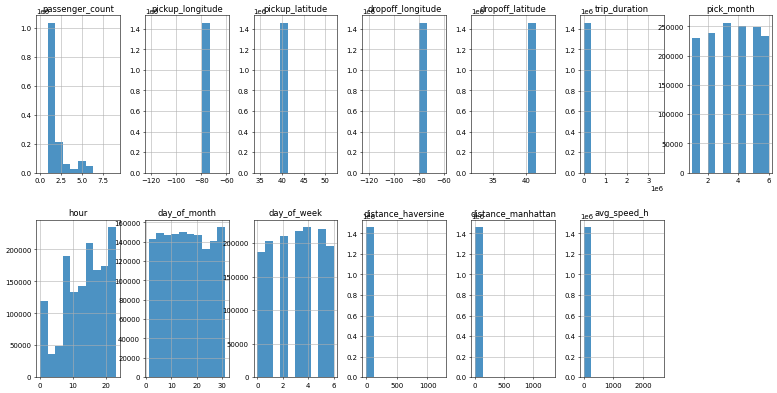

In [171]:
fig, ax = plt.subplots(figsize=(19,15), dpi=50)
train.hist(ax=ax, layout=(3,7), alpha=0.8)

There are short rides with less than 10 seconds and long rides more than 12 days

In [172]:
# removing the outliers
print(train.shape)
train = train[train['trip_duration'] >= 10]
train = train[train['trip_duration'] <= 72000] #20*3600
train = train[train['passenger_count'] > 0]
print(train.shape)

(1458644, 16)
(1454692, 16)


In [173]:
print(test.shape)
test = test[test['passenger_count'] > 0]
print(test.shape)

(625134, 14)
(625111, 14)


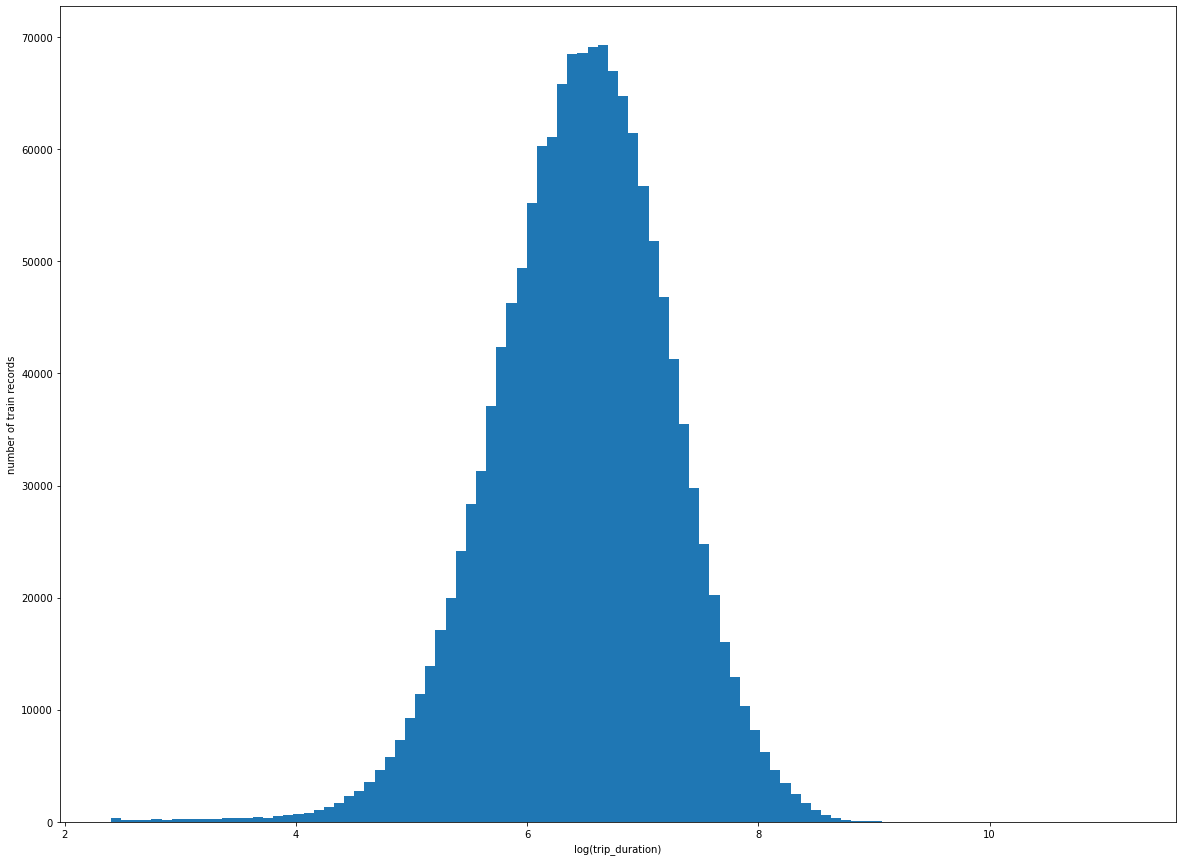

<AxesSubplot:xlabel='log_trip_duration', ylabel='Density'>

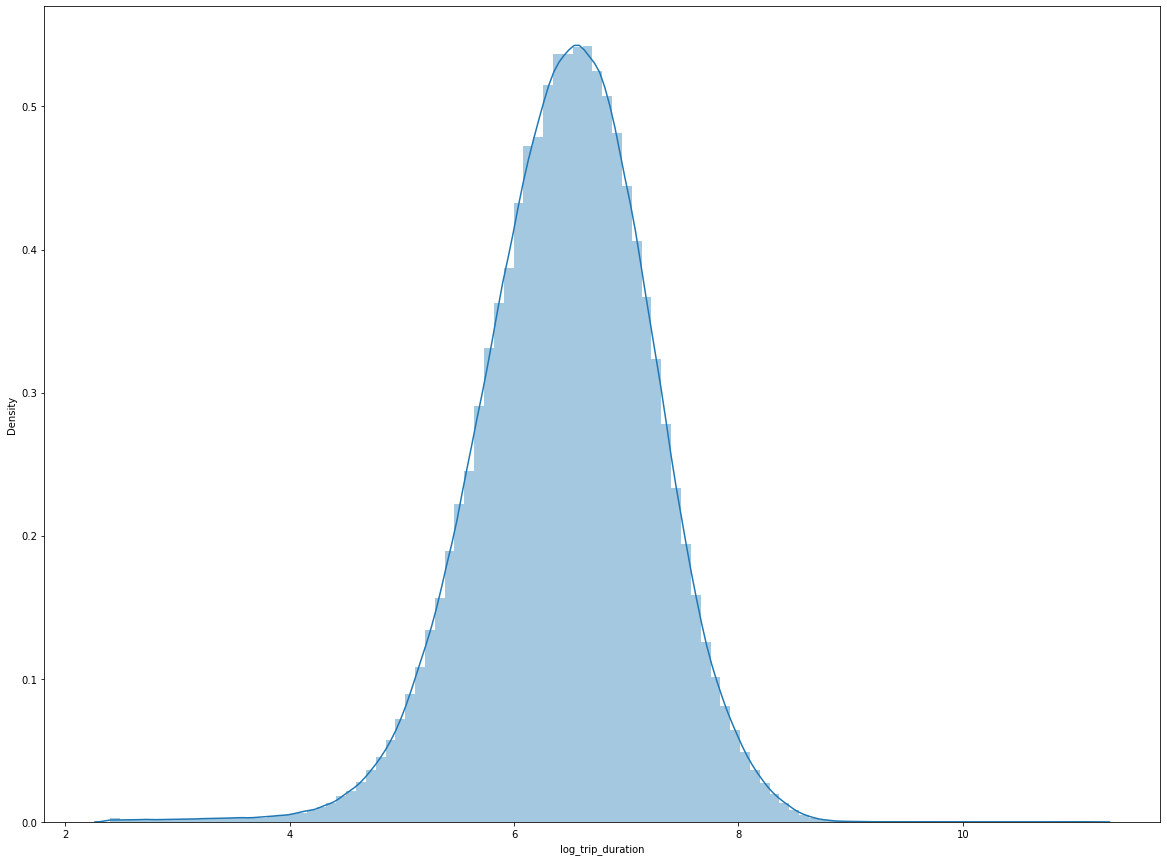

In [174]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()
sns.distplot(train["log_trip_duration"], bins =100)

In [175]:
# Using the IQR (Interquartile Range)

q3, q1 = np.percentile(train['trip_duration'], [75, 25])
print(q3, q1)
print(train.shape)
IQR = q3 - q1
print("IQR= ",IQR)

upper_bound = q3 + 1.5 * IQR
lower_bound = q1 - 1.5 * IQR
print("upper_bound= ", upper_bound)
print("lower_bound= ", lower_bound)
#train2=train.copy()
#train2 = train2[train2['trip_duration'] < upper_bound]
#train2 = train2[train2['trip_duration'] > lower_bound]
#print(train2.shape)

1074.0 398.0
(1454692, 17)
IQR=  676.0
upper_bound=  2088.0
lower_bound=  -616.0


Correlation between various features


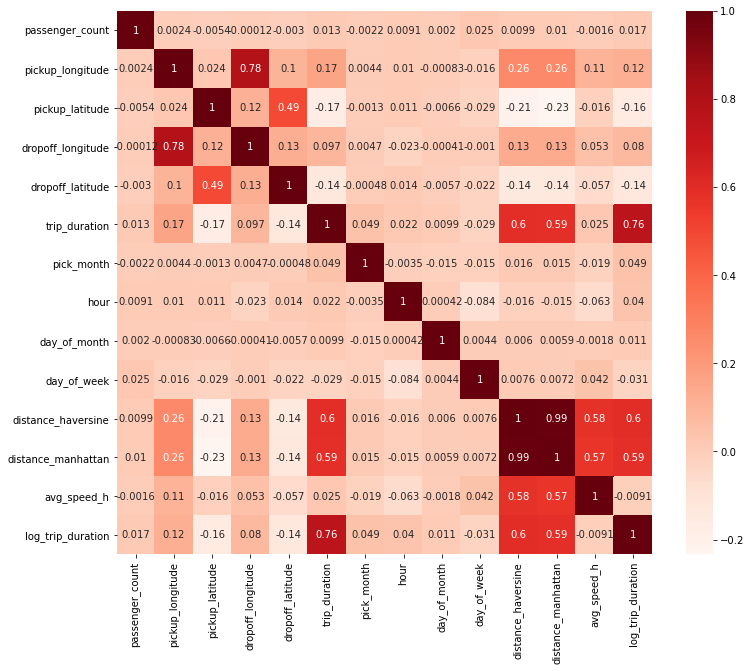

In [176]:
plt.figure(figsize=(12,10))
print('Correlation between various features')
p=sns.heatmap(train.corr(), annot=True,cmap ='Reds')

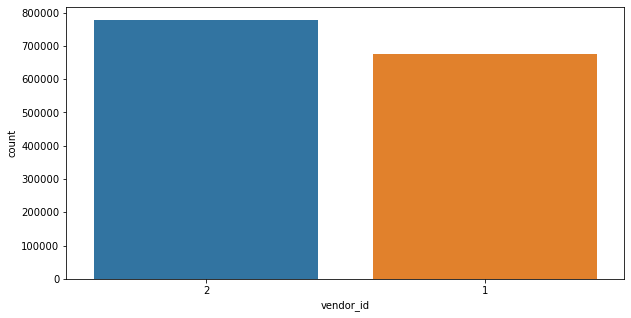

In [177]:
plt.rcParams['figure.figsize'] = [10, 5]
sns.countplot(x="vendor_id",data=train)
plt.show()

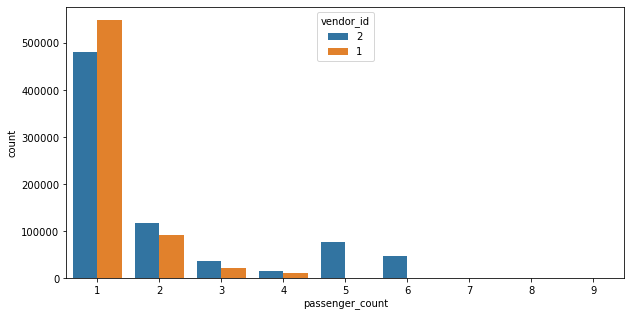

In [178]:
sns.countplot(x="passenger_count",data=train,hue="vendor_id")
plt.show()

The vast majority of rides had only a single passenger, with two passengers being the (distant) second most popular option.

Towards larger passenger numbers there is a smooth decline through 3 to 4, until the larger crowds (and larger cars) give us another peak at 5 to 6 passengers.



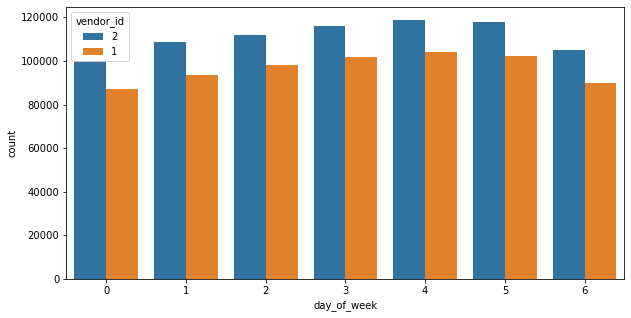

In [179]:
sns.countplot(x="day_of_week",data=train,hue="vendor_id")
plt.show()

Vendor 2 has significantly more trips in this data set than vendor 1. This is true for every day of the week.

Monday is the quietest day and Friday is the busiest. This is the same for the two different vendors.


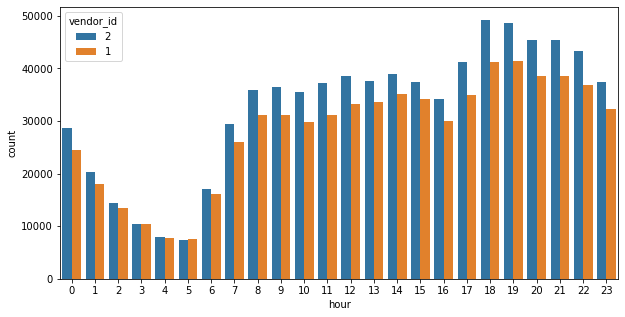

In [180]:
sns.countplot(x="hour",data=train,hue="vendor_id")
plt.show()

In [181]:
#train.loc[:, 'pick_month'] = train['pickup_datetime'].dt.month
#train.loc[:, 'hour'] = train['pickup_datetime'].dt.hour
#train.loc[:, 'day_of_month'] = train['pickup_datetime'].dt.day
#train.loc[:, 'day_of_week'] = train['pickup_datetime'].dt.dayofweek

In [182]:
train.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_duration', 'pick_month', 'hour', 'day_of_month', 'day_of_week',
       'distance_haversine', 'distance_manhattan', 'direction', 'avg_speed_h',
       'log_trip_duration'],
      dtype='object')

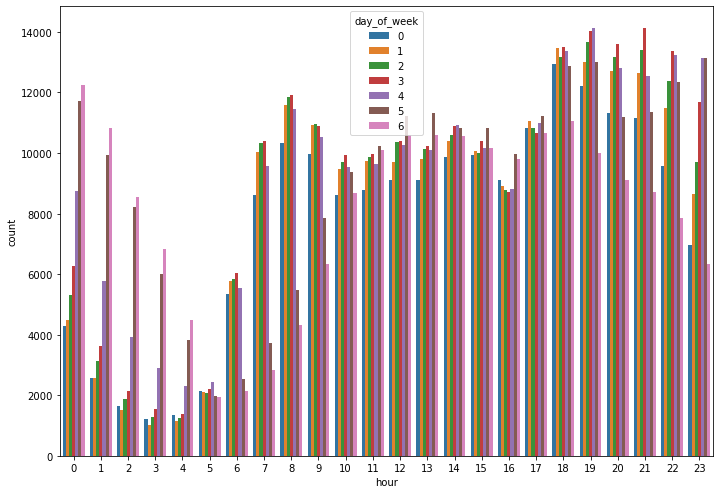

In [183]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
sns.countplot(x="hour",data=train,hue="day_of_week")
#sns.catplot(x="hour",data=df1,hue="wday", kind= "count")
plt.show()

The weekend (Sat and Sun, plus Fri to an extend) have higher trip numbers during the early morning hours but lower ones in the morning between 5 and 10, which can most likely be attributed to the contrast between NYC business days and weekend night life. In addition, trip numbers drop on a Sunday evening/night.

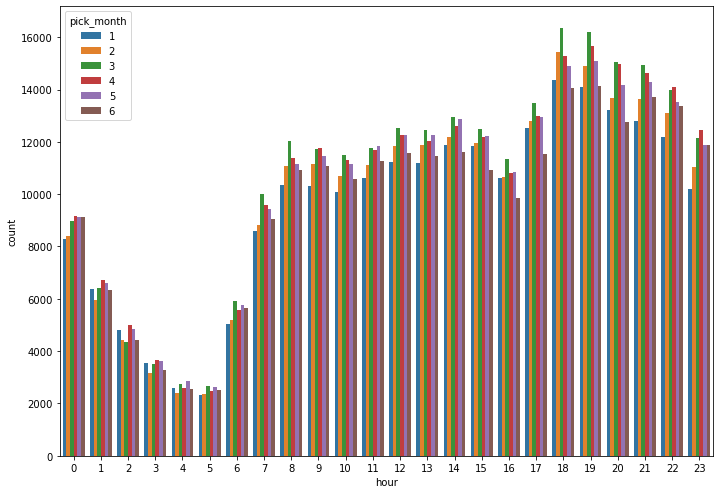

In [184]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
sns.countplot(x="hour",data=train,hue="pick_month")
#sns.catplot(x="hour",data=df1,hue="wday", kind= "count")
plt.show()

January and June have fewer trips, whereas March and April are busier months.

In [185]:
df2 = train.groupby(['hour', 'day_of_week', "vendor_id"]).agg(med_trip_duration=("trip_duration", 'median'))
df2 = df2.reset_index()
df2.head()

,hour,day_of_week,vendor_id,med_trip_duration
0,0,0,1,594.0
1,0,0,2,601.5
2,0,1,1,597.0
3,0,1,2,588.5
4,0,2,1,597.0


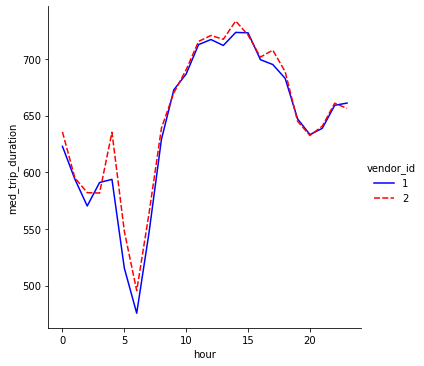

In [186]:
sns.color_palette("rocket")
sns.relplot(x="hour",y="med_trip_duration",data=df2,kind="line", hue="vendor_id",\
            style="vendor_id", ci=None, palette=["b", "r"])
plt.show()

Vendor 2, the one with the more frequent trips, also has consistently higher trip durations than vendor 1. It will be worth adding the vendor_id feature to a model to test its predictive importance.

Over the course of a typical day there is a peak in the early afternoon and dips around 5-6am and 8pm.

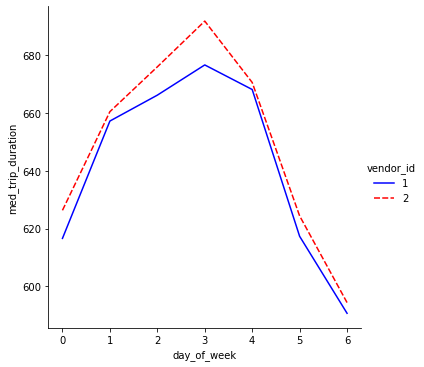

In [187]:
sns.relplot(x="day_of_week",y="med_trip_duration",data=df2,kind="line", hue="vendor_id",\
            style="vendor_id", ci=None, palette=["b", "r"])
plt.show()

The weekday and hour of a trip appear to be important features for predicting its duration and should be included in the model.

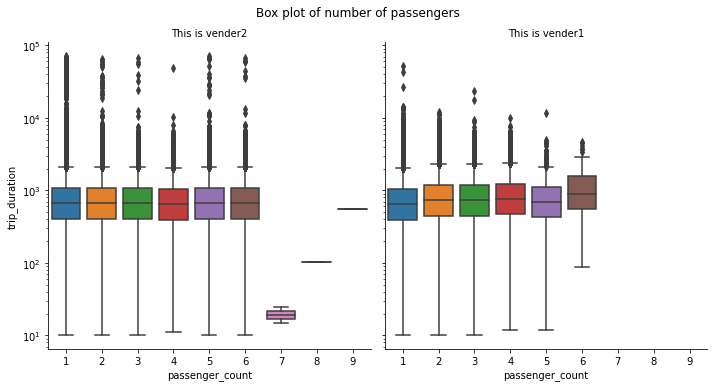

In [188]:
g = sns.catplot(x="passenger_count",y="trip_duration",data=train,kind="box",col="vendor_id")
g.set(yscale="log")
g.fig.suptitle("Box plot of number of passengers",y=1.03)
g.set_titles("This is vender{col_name}")

No handles with labels found to put in legend.


Text(0, 0.5, 'Time in Seconds')

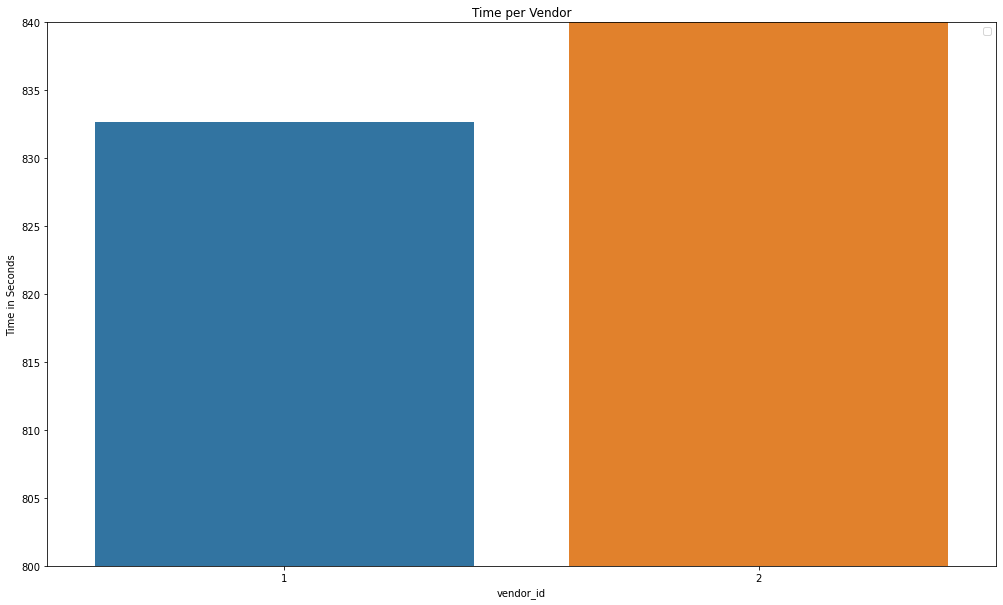

In [189]:
import warnings
warnings.filterwarnings("ignore")
plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
sns.barplot(plot_vendor.index,plot_vendor.values)
plt.title('Time per Vendor')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')

No handles with labels found to put in legend.


<AxesSubplot:xlabel='passenger_count', ylabel='Time in Seconds'>

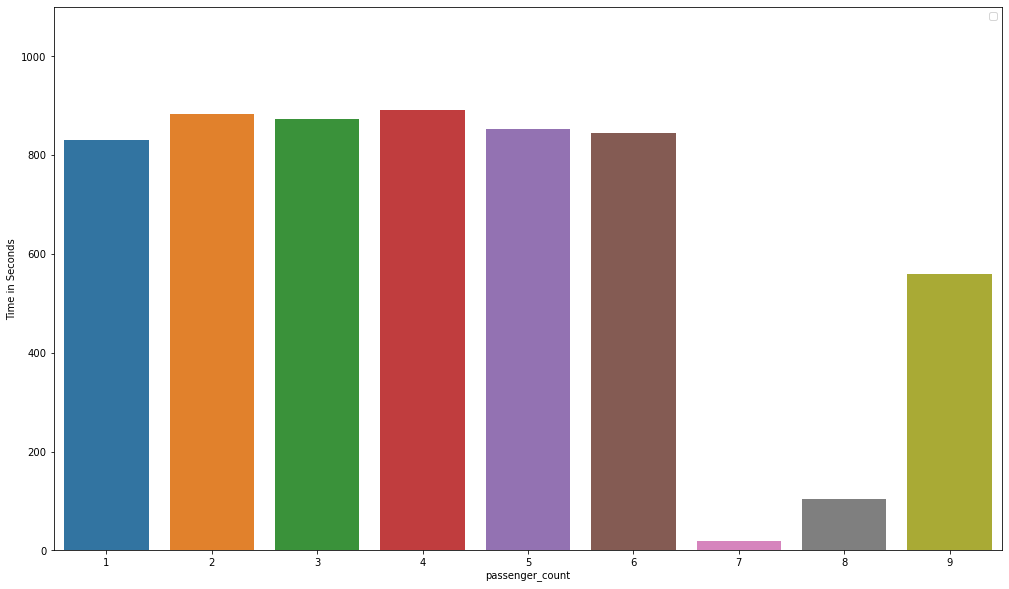

In [190]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1,1,figsize=(17,10))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
#plt.title('Time per store_and_fwd_flag')
plt.legend(loc=0)
plt.ylabel('Time in Seconds')
sns.barplot(pc.index,pc.values)

In [191]:
train.groupby('passenger_count').size()

passenger_count
1    1030661
2     209901
3      59755
4      28342
5      77838
6      48190
7          3
8          1
9          1
dtype: int64

In [192]:
test.groupby('passenger_count').size()

passenger_count
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

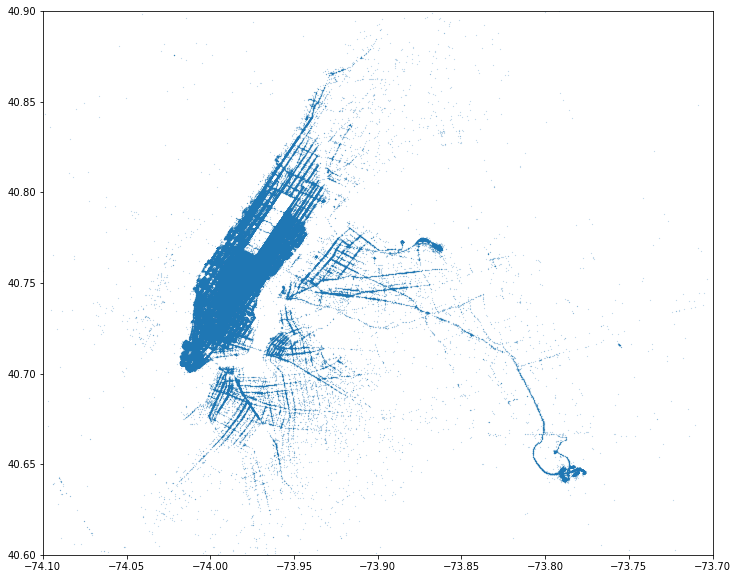

In [193]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(train['pickup_longitude'],train['pickup_latitude'], s=0.01, alpha=1)

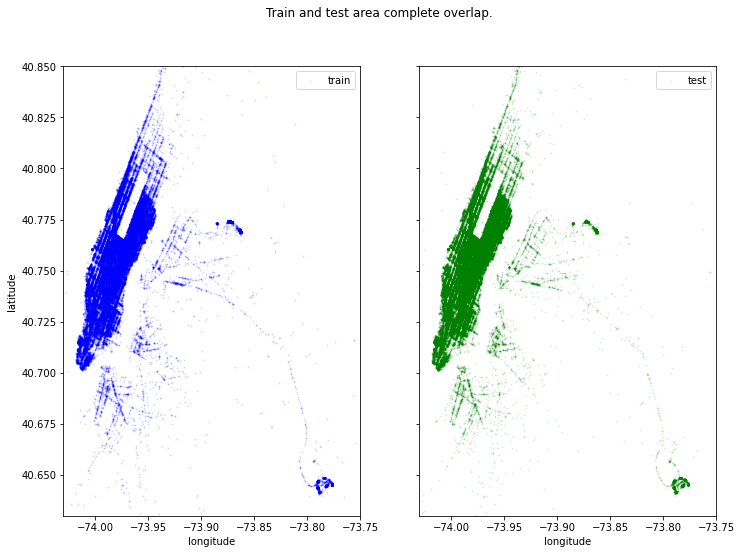

In [194]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [195]:
train.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_duration', 'pick_month', 'hour', 'day_of_month', 'day_of_week',
       'distance_haversine', 'distance_manhattan', 'direction', 'avg_speed_h',
       'log_trip_duration'],
      dtype='object')

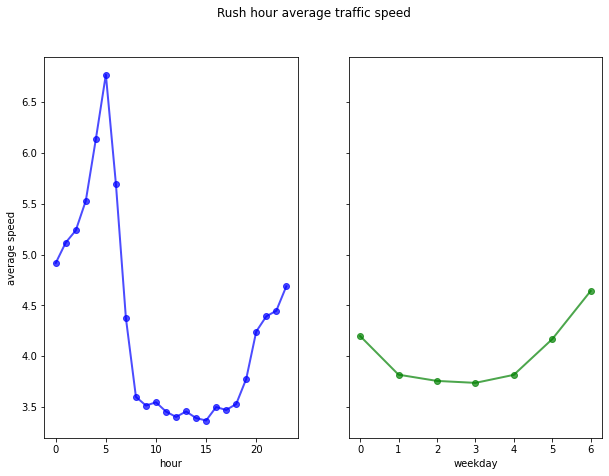

In [196]:
fig, ax = plt.subplots(ncols=2, sharey=True,figsize=(10, 7))
ax[0].plot(train.groupby('hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(train.groupby('day_of_week').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)
ax[0].set_xlabel('hour')
ax[1].set_xlabel('weekday')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

As we can see, because at 5am less people using Taxi so the street won't be crowed  

  speed will be high. The opposite is true for hours around 16-20pm.
On Monday and Sunday, the speed is higher than other days.

some notes:


pickup_longtitude, pickup_latitude, dropoff_longtitude, dropoff_latitude have some values which dominate because in this problem we focus on New York city.

People in New York tends to go alone (passenger = 1)

pick_month: in March, the number of people using Taxi is the highest.

hour: less people uses Taxi at 5am and more at 16-20pm.

day_of_week: on Monday and Sunday, less people uses Taxi

day_of_month: at the end of a month, the number of human using Taxi decreases.

2 types of distance and average speed have no much different.

Trip duration is calcuated by second so the range is quite big (1e6) and there are some values that occur most of the time.

In [197]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [198]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [199]:
train['pickup_cluster'].value_counts()

39    67075
42    48803
29    42326
14    41332
5     40472
      ...  
76      191
28      179
60      152
30      137
33      132
Name: pickup_cluster, Length: 100, dtype: int64

In [200]:
train['pickup_cluster'].unique()

array([45, 38, 17, 72, 34, 89,  0, 48, 39, 80, 99, 24,  5, 70, 86, 66, 36,
       92, 97,  4, 31, 73, 96, 41, 27, 91, 83, 42, 37, 79, 49, 40, 98, 25,
        6, 88, 47,  2, 10, 14, 29, 74, 56, 59, 68, 20, 94, 57, 71, 16, 12,
       55, 84,  1, 22,  3, 13,  8,  9, 69, 51, 23, 21, 44, 62, 53, 32, 63,
       19, 61, 50, 65, 35, 67, 75, 95,  7, 54, 90, 77, 81, 18, 78, 30, 87,
       26, 82, 11, 64, 43, 15, 28, 52, 46, 58, 93, 85, 33, 76, 60])

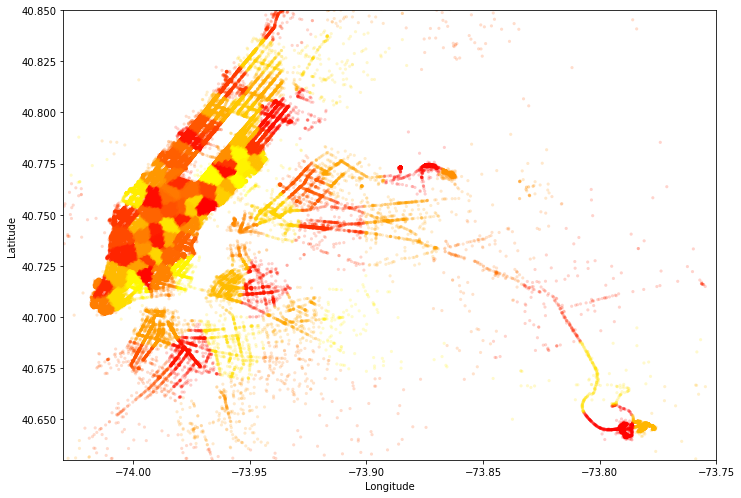

In [201]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(train.pickup_longitude.values[:500000], train.pickup_latitude.values[:500000], s=10, lw=0,
           c=train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [202]:
for gby_cols in [['hour', 'pickup_cluster'],  ['hour', 'dropoff_cluster'],
                 ['pickup_cluster', 'dropoff_cluster']]:
    coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
    coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
    coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
    coord_stats = coord_stats[coord_stats['id'] > 100]
    coord_stats.columns = gby_cols + ['avg_speed_h_%s' % '_'.join(gby_cols), 'cnt_%s' %  '_'.join(gby_cols)]
    train = pd.merge(train, coord_stats, how='left', on=gby_cols)
    test = pd.merge(test, coord_stats, how='left', on=gby_cols)

In [203]:
train.columns

Index(['id', 'vendor_id', 'passenger_count', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'trip_duration', 'pick_month', 'hour', 'day_of_month', 'day_of_week',
       'distance_haversine', 'distance_manhattan', 'direction', 'avg_speed_h',
       'log_trip_duration', 'pickup_cluster', 'dropoff_cluster',
       'avg_speed_h_hour_pickup_cluster', 'cnt_hour_pickup_cluster',
       'avg_speed_h_hour_dropoff_cluster', 'cnt_hour_dropoff_cluster',
       'avg_speed_h_pickup_cluster_dropoff_cluster',
       'cnt_pickup_cluster_dropoff_cluster'],
      dtype='object')

In [204]:
num_cols = list(train.select_dtypes(exclude='object').columns)
cate_cols = list(train.select_dtypes(include='object').columns)

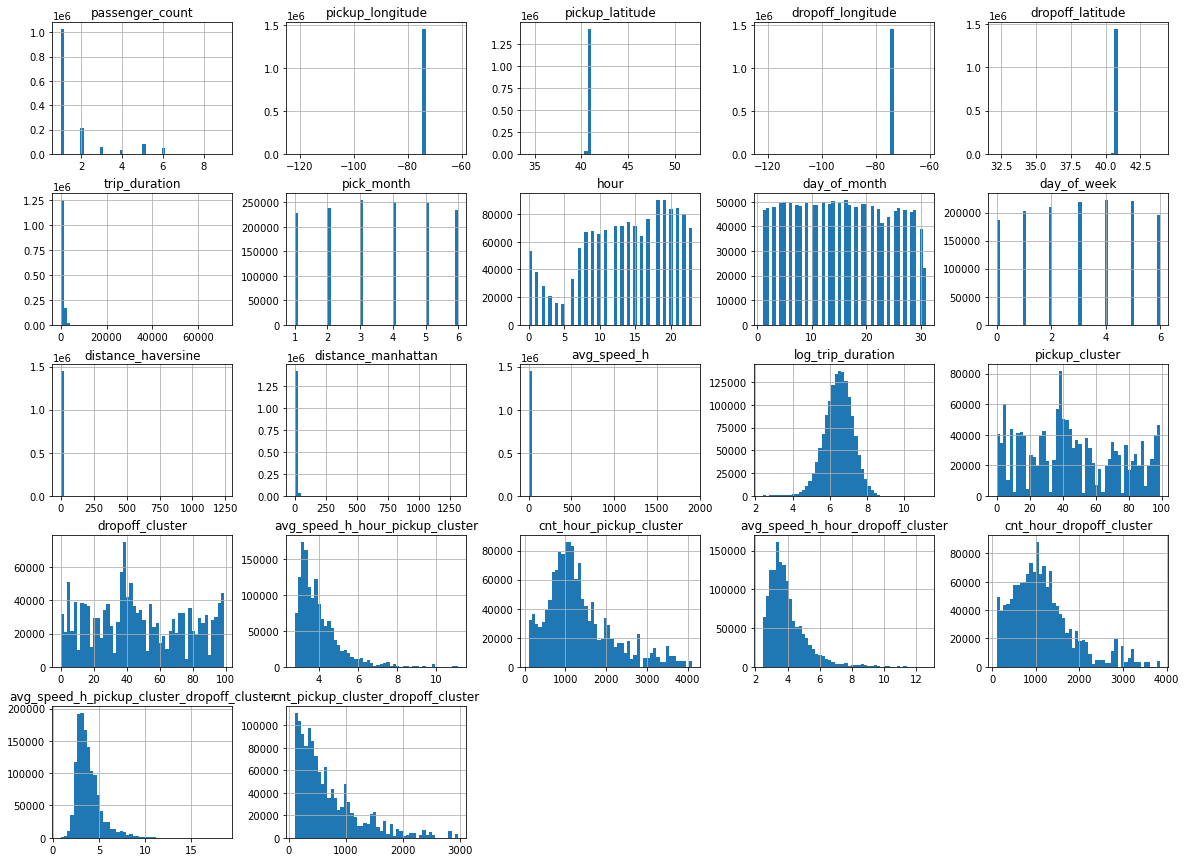

In [205]:
train[num_cols].hist(figsize=(20, 15), bins = 50)
plt.show()

In [206]:
def draw_chart(df, fig_size = (15,15)):
    temp = list(df.columns)
    figure, axis = plt.subplots(len(temp)//2 if len(temp) % 2 == 0 else len(temp)//2 + 1, 2, figsize = fig_size)
    color = ['#582f0e','#936639','#f3722c','#c2c5aa','#414833','#457b9d','#ffb703','#e63946', '#c77dff','#55a630','#f72585','#ffa69e','#4d908e','#7f5539','#b5e48c','#b6ad90','#38b000','#a84c32','#a84c32','#471f13','#8c842d','#408061']
    for i, col in enumerate(temp):
        t = df[col].value_counts()
        axis[i//2, i%2].scatter(list(t.index), t.values, color = color[i])
        axis[i//2, i%2].set_title(col)
    if len(temp) %2 !=0:
        figure.delaxes(axis[len(temp)//2,1])
    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=0.5, wspace=0.4)
    plt.show()

Both vendors have short trips without any passengers.

Between 1 and 6 passengers the median trip durations are remarkably similar, in particular for vendor 2. There might be differences for vendor 1, but they are small.

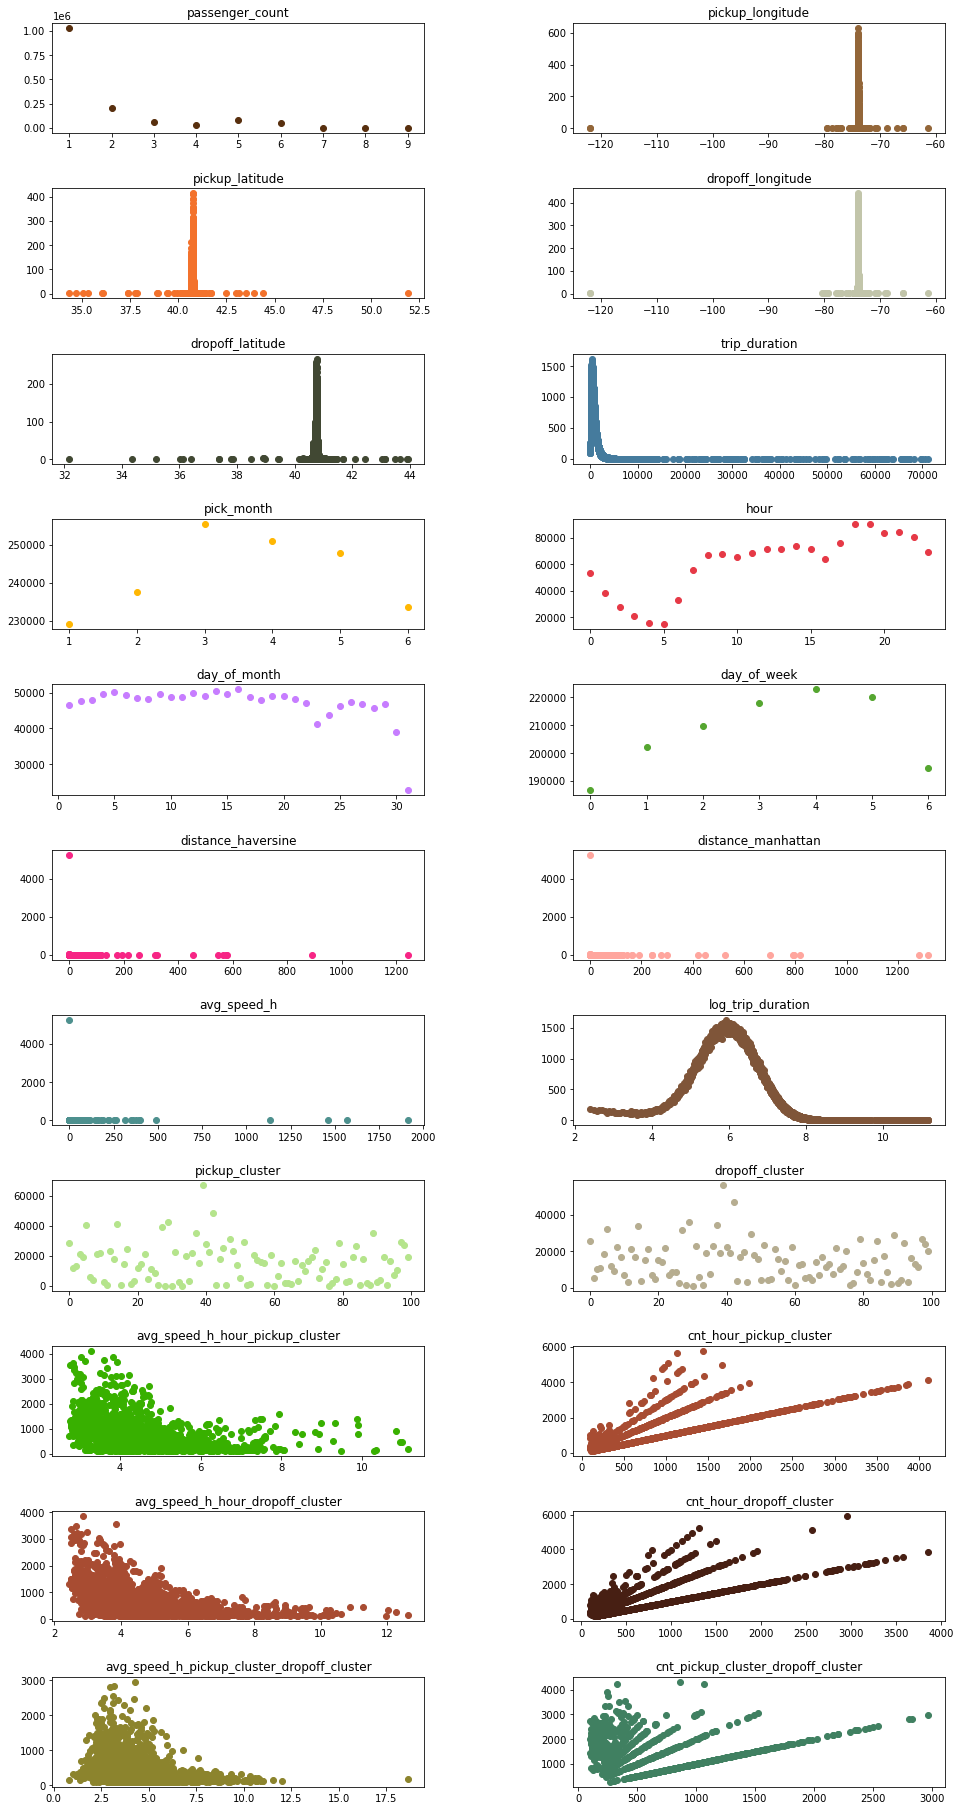

In [207]:
draw_chart(train[num_cols], (16,25));

The effect of each column on predicting trip_duration:

id: id of trip => does not related to trip duration => do not use to predict trip duration.

passenger_count: the number of passengers does not indicate the speed of that taxi => do not use to predict trip duration.

Features from pickup_datetime: pick_month, hour, day_of_month, day_of_week: this is the basic information of time => Based on those, we can know on which time, the number of vehicles will increase. We do not add minute column because this column is too detail or that can be known by other previous added columns => Feed to model.

avg_speed_h: do not use these columns to predict the trip duration because they are calculated based on the target column.

=> Features rejected: id, passenger_count, trip_duration, avg_speed_h.

=> Features used:

vendor_id
pick_month
hour
day_of_month
day_of_week
distance_haversine
distance_manhattan
direction
pickup_cluster
dropoff_cluster
avg_speed_h_hour_pickup_cluster
avg_speed_h_hour_dropoff_cluster
avg_speed_h_pickup_cluster_dropoff_cluster
cnt_hour_pickup_cluster
cnt_hour_dropoff_cluster
cnt_pickup_cluster_dropoff_cluster
pickup_longitude
pickup_latitude
dropoff_longitude
dropoff_latitude

In [208]:
train = train.drop(columns = ['passenger_count', 'avg_speed_h'])
test = test.drop(columns = ['passenger_count'])

In [209]:
train.cnt_pickup_cluster_dropoff_cluster

0           685.0
1           425.0
2           132.0
3           715.0
4          1767.0
            ...  
1454687     616.0
1454688     130.0
1454689       NaN
1454690     550.0
1454691    1387.0
Name: cnt_pickup_cluster_dropoff_cluster, Length: 1454692, dtype: float64

In [210]:
train.head()

,id,vendor_id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pick_month,hour,day_of_month,...,direction,log_trip_duration,pickup_cluster,dropoff_cluster,avg_speed_h_hour_pickup_cluster,cnt_hour_pickup_cluster,avg_speed_h_hour_dropoff_cluster,cnt_hour_dropoff_cluster,avg_speed_h_pickup_cluster_dropoff_cluster,cnt_pickup_cluster_dropoff_cluster
0,id2875421,2,-73.982155,40.767937,-73.964630,40.765602,455,3,17,14,...,N,6.122493,45,98,3.102208,1447.0,3.159945,1538.0,3.061823,685.0
1,id2377394,1,-73.980415,40.738564,-73.999481,40.731152,663,6,0,12,...,SW,6.498282,38,14,4.718804,418.0,3.787891,1413.0,2.828348,425.0
2,id3858529,2,-73.979027,40.763939,-74.005333,40.710087,2124,1,11,19,...,W,7.661527,17,86,3.044941,1152.0,3.890098,832.0,4.408868,132.0
3,id3504673,2,-74.010040,40.719971,-74.012268,40.706718,429,4,19,6,...,W,6.063785,72,49,3.821325,1598.0,4.651317,746.0,3.375699,715.0
4,id2181028,2,-73.973053,40.793209,-73.972923,40.782520,435,3,13,26,...,W,6.077642,34,8,4.258907,1152.0,3.941659,1177.0,4.440884,1767.0


In [213]:
train.drop(['log_trip_duration'], axis =1, inplace= True)
train.to_csv('features_train.csv', index=False)
test.to_csv('features_test.csv', index=False)

In [214]:
train = pd.read_csv('features_train.csv')
test = pd.read_csv('features_test.csv')

In [215]:
do_not_use_for_training = ['id','trip_duration']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]


In [216]:
print(len(feature_names_test)) 
feature_names_test

20


['vendor_id',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pick_month',
 'hour',
 'day_of_month',
 'day_of_week',
 'distance_haversine',
 'distance_manhattan',
 'direction',
 'pickup_cluster',
 'dropoff_cluster',
 'avg_speed_h_hour_pickup_cluster',
 'cnt_hour_pickup_cluster',
 'avg_speed_h_hour_dropoff_cluster',
 'cnt_hour_dropoff_cluster',
 'avg_speed_h_pickup_cluster_dropoff_cluster',
 'cnt_pickup_cluster_dropoff_cluster']

In [217]:
print(len(feature_names)) 
feature_names

20


['vendor_id',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'pick_month',
 'hour',
 'day_of_month',
 'day_of_week',
 'distance_haversine',
 'distance_manhattan',
 'direction',
 'pickup_cluster',
 'dropoff_cluster',
 'avg_speed_h_hour_pickup_cluster',
 'cnt_hour_pickup_cluster',
 'avg_speed_h_hour_dropoff_cluster',
 'cnt_hour_dropoff_cluster',
 'avg_speed_h_pickup_cluster_dropoff_cluster',
 'cnt_pickup_cluster_dropoff_cluster']

In [224]:
y = np.log(train['trip_duration'].values + 1)

In [219]:
dtrain = train[feature_names]
dtest = test[feature_names]

In [220]:
dtrain.isnull().sum()

vendor_id                                          0
pickup_longitude                                   0
pickup_latitude                                    0
dropoff_longitude                                  0
dropoff_latitude                                   0
pick_month                                         0
hour                                               0
day_of_month                                       0
day_of_week                                        0
distance_haversine                                 0
distance_manhattan                                 0
direction                                          0
pickup_cluster                                     0
dropoff_cluster                                    0
avg_speed_h_hour_pickup_cluster                23385
cnt_hour_pickup_cluster                        23385
avg_speed_h_hour_dropoff_cluster               20562
cnt_hour_dropoff_cluster                       20562
avg_speed_h_pickup_cluster_dropoff_cluster    

In [225]:
num_cols = list(dtrain.select_dtypes(exclude='object').columns)
cat_cols = list(dtrain.select_dtypes(include='object').columns)

In [226]:
#Preprocessing for missing numerical data
num_transformer = Pipeline(steps = [
         ("imputer", SimpleImputer(strategy="constant", fill_value=0)),
         ("norm", StandardScaler())])

# Preprocessing for categorical data
cat_transformer = OneHotEncoder(handle_unknown="ignore", sparse=False)

# getting together our scaler and encoder with preprocessor
preprocessor = ColumnTransformer(
      transformers=[('num', num_transformer, num_cols),
                    ('cat', cat_transformer, cat_cols)])
X_train, X_val, y_train, y_val = train_test_split(dtrain, y, test_size=0.2, random_state=1987)

In [227]:
model_linear = LinearRegression()

# giving all values to pipeline
linear_pipe = Pipeline(steps=[('preprocessor', preprocessor),('linear', model_linear)])
linear_pipe.fit(X_train, y_train)

# make predictions on training set
y_pred = linear_pipe.predict(X_val)

In [228]:
print(linear_pipe)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('norm',
                                                                   StandardScaler())]),
                                                  ['vendor_id',
                                                   'pickup_longitude',
                                                   'pickup_latitude',
                                                   'dropoff_longitude',
                                                   'dropoff_latitude',
                                                   'pick_month', 'hour',
                                                 

In [229]:
 #to print the results in good way
print(f"Validation RMSLE: {mean_squared_error(y_pred, y_val, squared=False)}")

Validation RMSLE: 0.5241187237408721


In [230]:
y_pre_linear = linear_pipe.predict(dtest)
y_pre_linear = np.exp(y_pre_linear) - 1
y_pre_linear

array([ 837.97233687,  638.68973924,  476.33958194, ..., 1301.30396918,
       4605.09123339, 1096.10179077])

In [231]:
new_df = test.copy()
new_df['trip_duration'] = y_pre_linear
new_df = new_df[['id', 'trip_duration']]
new_df.head()

,id,trip_duration
0,id3004672,837.972337
1,id3505355,638.689739
2,id1217141,476.339582
3,id2150126,980.756448
4,id1598245,536.720150


In [233]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=1000, min_samples_leaf=50, min_samples_split=75)

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor),('rf', rf_model)])
rf_pipe.fit(X_train, y_train)
y_pred_rf = rf_pipe.predict(X_val)


KeyboardInterrupt: 

In [232]:
print(rf_pipe)

NameError: name 'rf_pipe' is not defined